In [1]:
# kernel auto reload modules when the underlying code is chaneged, instead of having to reset the runtime.
%load_ext autoreload
%autoreload 2

In [2]:
!pwd

/root/class/cmu/DL/hw2p2


In [3]:
from run import train, test, inference, face_embedding, verification_inference, gen_cls_submission, gen_ver_submission

In [4]:
from copy import deepcopy
import os
from tqdm import tqdm
from glob import glob

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision
import torchvision.transforms as ttf
from torch.cuda.amp import GradScaler, autocast
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, roc_auc_score
import hydra
from omegaconf import OmegaConf
import wandb

from models.cnn import BaselineCNN, VGG16
from models.resnet import resnet34, resnet50, myresnet
from datasets.classification import ClassificationTestSet
from datasets.verification import VerificationDataset
from datasets.transform import AlbumTransforms, train_transforms, val_transforms
from utils.utils import weight_decay_custom, compute_kl_loss, SAM

In [5]:
from torchsummary import summary

In [6]:
import timm
timm.list_models('*convnext*')

['convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [7]:
import timm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = timm.create_model('convnext_tiny', num_classes=7000).to(device)
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
       LayerNorm2d-2           [-1, 96, 56, 56]             192
          Identity-3           [-1, 96, 56, 56]               0
            Conv2d-4           [-1, 96, 56, 56]           4,800
         LayerNorm-5           [-1, 56, 56, 96]             192
            Linear-6          [-1, 56, 56, 384]          37,248
              GELU-7          [-1, 56, 56, 384]               0
           Dropout-8          [-1, 56, 56, 384]               0
            Linear-9           [-1, 56, 56, 96]          36,960
          Dropout-10           [-1, 56, 56, 96]               0
              Mlp-11           [-1, 56, 56, 96]               0
         Identity-12           [-1, 96, 56, 56]               0
    ConvNeXtBlock-13           [-1, 96, 56, 56]               0
           Conv2d-14           [-1, 96,

In [7]:
import timm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = timm.create_model('resnet50', num_classes=7000).to(device)
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [8]:
from models.resnet import resnet18, resnet50, myresnet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet50().to(device)
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              GELU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              GELU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             GELU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [7]:
BASE_DIR = '/shared/youngkim/hw2p2'
CLS_DIR = os.path.join(BASE_DIR, '11-785-s22-hw2p2-classification')
VER_DIR = os.path.join(BASE_DIR, '11-785-s22-hw2p2-verification')

CLS_TRAIN_DIR = os.path.join(CLS_DIR, "train_subset/train_subset") # This is a smaller subset of the data. Should change this to classification/classification/train
CLS_VAL_DIR = os.path.join(CLS_DIR, "classification/classification/dev")
CLS_TEST_DIR = os.path.join(CLS_DIR, "classification/classification/test")

VER_VAL_DIR = os.path.join(VER_DIR, 'verification/verification/dev')
VER_TEST_DIR = os.path.join(VER_DIR, 'verification/verification/test')

from albumentations.pytorch import ToTensorV2


# train_dataset = torchvision.datasets.ImageFolder(CLS_TRAIN_DIR,
#                                                 transform=AlbumTransforms(ToTensorV2()))
train_dataset = torchvision.datasets.ImageFolder(CLS_TRAIN_DIR,
                                                transform=AlbumTransforms(train_transforms))
val_dataset = torchvision.datasets.ImageFolder(CLS_VAL_DIR,
                                                transform=AlbumTransforms(val_transforms))
test_dataset = ClassificationTestSet(CLS_TEST_DIR, AlbumTransforms(val_transforms))

train_loader = DataLoader(train_dataset, batch_size=8,
                        shuffle=True, drop_last=True, num_workers=2)
valid_loader = DataLoader(val_dataset, batch_size=8, shuffle=False,
                        drop_last=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False,
                        drop_last=False, num_workers=1)

val_veri_dataset = VerificationDataset(VER_VAL_DIR,
                                        AlbumTransforms(val_transforms))
test_veri_dataset = VerificationDataset(VER_TEST_DIR,
                                        AlbumTransforms(val_transforms))

val_ver_loader = torch.utils.data.DataLoader(val_veri_dataset, batch_size=8, 
                                                shuffle=False, num_workers=1)
test_ver_loader = torch.utils.data.DataLoader(test_veri_dataset, batch_size=8, 
                                                shuffle=False, num_workers=1)

In [8]:
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
face_norm_mean = (0.511, 0.402, 0.351)
face_norm_std = (0.270, 0.235, 0.222)
invTrans = transforms.Compose([ 
    transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.270, 1/0.235, 1/0.222 ]),
    transforms.Normalize(mean = [ -0.511, -0.402, -0.351 ], std = [ 1., 1., 1. ])])


X.shape = torch.Size([8, 3, 224, 224]) / Y.shape = torch.Size([8])



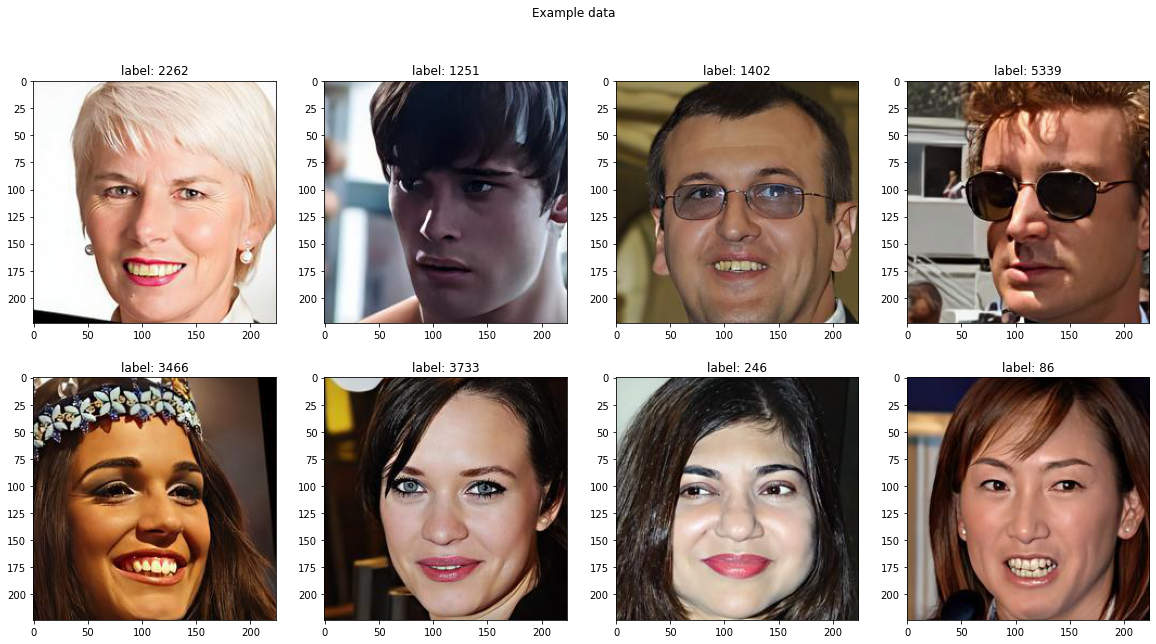

In [9]:

for batch in train_loader:
    images, labels = batch
    break

print(f'X.shape = {images.shape} / Y.shape = {labels.shape}\n')

row = 2
column = 4
fig, axis = plt.subplots(row, column, figsize=(20,10))
fig.suptitle(f'Example data')
for i, ax in enumerate(axis.flatten()):
    ax.imshow(invTrans(images[i, :, :, :]).permute(1, 2, 0))
    ax.set_title(f'label: {labels[i]}')
plt.show()


In [10]:
images[0]

tensor([[[ 1.6804,  1.6804,  1.6804,  ...,  1.7094,  1.7094,  1.7094],
         [ 1.6804,  1.6804,  1.6804,  ...,  1.7240,  1.7094,  1.7094],
         [ 1.6804,  1.6804,  1.6804,  ...,  1.7094,  1.7240,  1.7094],
         ...,
         [-1.8490, -1.8490, -1.8490,  ...,  1.3463,  1.3463,  1.3318],
         [-1.8200, -1.8200, -1.8200,  ...,  1.3463,  1.3318,  1.3318],
         [-1.8200, -1.8200, -1.8200,  ...,  1.3318,  1.3318,  1.3318]],

        [[ 2.3945,  2.3945,  2.3945,  ...,  2.3945,  2.3945,  2.3945],
         [ 2.3945,  2.3945,  2.3945,  ...,  2.4112,  2.3945,  2.3945],
         [ 2.3945,  2.3945,  2.3945,  ...,  2.4279,  2.4112,  2.3945],
         ...,
         [-1.6940, -1.6940, -1.6940,  ...,  1.9940,  1.9940,  1.9773],
         [-1.6940, -1.6940, -1.6940,  ...,  1.9940,  1.9773,  1.9773],
         [-1.6940, -1.6940, -1.6940,  ...,  1.9773,  1.9773,  1.9773]],

        [[ 2.7644,  2.7644,  2.7644,  ...,  2.8174,  2.8174,  2.8174],
         [ 2.7644,  2.7644,  2.7644,  ...,  2

X.shape = torch.Size([8, 3, 224, 224]) / Y.shape = torch.Size([8])



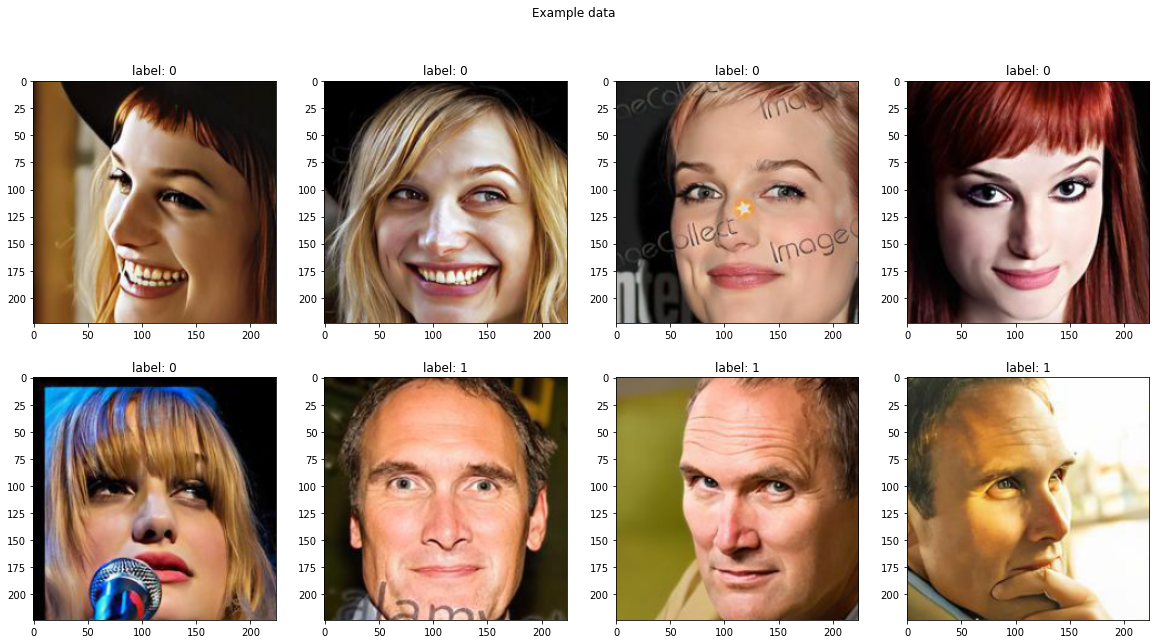

In [8]:
for batch in valid_loader:
    images, labels = batch
    break

print(f'X.shape = {images.shape} / Y.shape = {labels.shape}\n')

row = 2
column = 4
fig, axis = plt.subplots(row, column, figsize=(20,10))
fig.suptitle(f'Example data')
for i, ax in enumerate(axis.flatten()):
    ax.imshow(invTrans(images[i, :, :, :]).permute(1, 2, 0))
    ax.set_title(f'label: {labels[i]}')
plt.show()

In [8]:
# To normalize the dataset, calculate the mean and std
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_dataset]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_dataset]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])


# val_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in val_dataset]
# val_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in val_dataset]

# val_meanR = np.mean([m[0] for m in val_meanRGB])
# val_meanG = np.mean([m[1] for m in val_meanRGB])
# val_meanB = np.mean([m[2] for m in val_meanRGB])

# val_stdR = np.mean([s[0] for s in val_stdRGB])
# val_stdG = np.mean([s[1] for s in val_stdRGB])
# val_stdB = np.mean([s[2] for s in val_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(train_stdR, train_stdG, train_stdB)
# print(val_meanR, val_meanG, val_meanB)
# print(val_stdR, val_stdG, val_stdB)

130.84052357473124 102.87826150407705 89.8078322146046
69.0270646278393 60.27228972930031 56.77029361990503


In [14]:
print(train_meanR/256, train_meanG/256, train_meanB/256)
print(train_stdR/256, train_stdG/256, train_stdB/256)

0.5110957952137939 0.40186820900030096 0.3508118445882992
0.26963697120249724 0.23543863175507934 0.22175895945275403


In [6]:
# To normalize the dataset, calculate the mean and std
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_dataset]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_dataset]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])


val_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in val_dataset]
val_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in val_dataset]

val_meanR = np.mean([m[0] for m in val_meanRGB])
val_meanG = np.mean([m[1] for m in val_meanRGB])
val_meanB = np.mean([m[2] for m in val_meanRGB])

val_stdR = np.mean([s[0] for s in val_stdRGB])
val_stdG = np.mean([s[1] for s in val_stdRGB])
val_stdB = np.mean([s[2] for s in val_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(val_meanR, val_meanG, val_meanB)

0.20153274 -0.18336688 -0.20368218
0.23531331 -0.17592779 -0.20548391


In [7]:
print(train_stdR, train_stdG, train_stdB)
print(val_stdR, val_stdG, val_stdB)

1.1156596 0.99193615 0.9215865
1.1455073 1.0143957 0.9435556


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16().to(device)
print(device)

cuda


In [9]:
checkpoint = torch.load('/shared/youngkim/hw2p2/weights/vgg16.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Model loaded: {'/shared/youngkim/hw2p2/weights/vgg16.pth'}")

Model loaded: /shared/youngkim/hw2p2/weights/vgg16.pth


In [ ]:
best_model = model

val_feats_dict = face_embedding(best_model, val_ver_loader, device)
    
val_veri_csv = os.path.join(VER_DIR, "verification/verification/verification_dev.csv")
similarity_metric = nn.CosineSimilarity(dim=0)


In [19]:
list(val_feats_dict.items())[0][0]

'000b28b024.jpg'

In [14]:
list(val_feats_dict.items())[0][1].shape

torch.Size([512])

In [17]:
pd.read_csv(val_veri_csv).head()

,image_A,image_B,match
0,dev/ab001b21a1.jpg,dev/10246770ce.jpg,1
1,dev/c692b5fa6b.jpg,dev/299becf799.jpg,0
2,dev/d0dc5318e4.jpg,dev/3aac902136.jpg,0
3,dev/f9643ca7b5.jpg,dev/6f300f3205.jpg,1
4,dev/95ccb4131a.jpg,dev/3d207ca2b2.jpg,0


In [25]:
# Now, loop through the csv and compare each pair, getting the similarity between them
similarity_metric = nn.CosineSimilarity(dim=0)
similarity_metric.to(device)

pred_similarities = []
gt_similarities = []
for line in tqdm(open(val_veri_csv).read().splitlines()[1:], position=0, leave=True, desc='Veri'): # skip header
    img_path1, img_path2, gt = line.split(",")

    # TODO: Use the similarity metric
    # How to use these img_paths? What to do with the features?
    
    feat1 = val_feats_dict[img_path1.split("/")[-1]]
    feat2 = val_feats_dict[img_path2.split("/")[-1]]
    
    similarity = similarity_metric(feat1, feat2)

    pred_similarities.append(similarity.cpu())
    gt_similarities.append(int(gt))

pred_similarities = np.array(pred_similarities)
gt_similarities = np.array(gt_similarities)

auc = roc_auc_score(gt_similarities, pred_similarities)
print("AUC:", auc)

# auc = verification(val_veri_csv, val_feats_dict, similarity_metric, device)
# print("Verification AUC: ", auc)

Veri: 100%|██████████| 166800/166800 [00:12<00:00, 12946.29it/s]


AUC: 0.8937404067355124


In [26]:
test_feats_dict = face_embedding(best_model, test_ver_loader, device)

test_veri_csv = os.path.join(VER_DIR, "verification/verification/verification_test.csv")
pred_similarities = verification_inference(test_veri_csv, test_feats_dict, similarity_metric, device)

# gen_ver_submission
sub_path = '/shared/youngkim/hw2p2/submissions'
save_name = 'vgg16'
assert len(pred_similarities) == 667600
test_names = [i for i in range(len(pred_similarities))]
submission = pd.DataFrame(zip(test_names, pred_similarities), columns=['id', 'match'])
submission.to_csv(os.path.join(sub_path, f'{save_name}_ver_sub.csv'), index=False)

print("ver_submission saved.")

Veri_infer: 100%|██████████| 667600/667600 [00:52<00:00, 12762.08it/s]


ver_submission saved.
